In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! ls
!nvidia-smi

drive  sample_data
Sun May  8 17:26:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                     

In [3]:
# cd content/drive/MyDrive/cifar10_resnet

In [4]:
import csv
import numpy as np
!pip install emoji
import emoji
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.metrics import confusion_matrix

def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="UTF-8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def read_csv(filename = 'emojify_data.csv'):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y


emoji_dictionary = {"0": "\u2764\uFE0F",    # :heart: prints a black instead of red heart depending on the font
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)
              
    
def print_predictions(X, pred):
    print()
    for i in range(X.shape[0]):
        print(X[i], label_to_emoji(int(pred[i])))
        
        
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):
    
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    
    
def predict(X, Y, W, b, word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of your model over the given set.
    
    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label emoji, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    
    for j in range(m):                       # Loop over training examples
        
        # Split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()
        
        # Average words' vectors
        avg = np.zeros((50,))
        for w in words:
            avg += word_to_vec_map[w]
        avg = avg/len(words)

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    
    return pred

     |████████████████████████████████| 175 kB 14.1 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=a26f1cee121c0ee1e94e38d341515df0db9386d378cfc8b20616446fe973f7a7
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [5]:
import random
def createDataFiles(allDataFile,trainFile,testFile):  # Want to split into train and test, and put in separate (new) files
  test_indices = []
  for i in range(5):
    # print(min(range(40*i,40*(i+1))),max(range(40*i,40*(i+1))))
    test_indices += random.sample(range(40*i,40*(i+1)),6)
  
  with open(allDataFile,"r") as fileToRead:
    csvReader = csv.reader(fileToRead)
    i = 0
    mode1,mode2 = "w","w"
    for row in csvReader:
      if i in test_indices:
        file = testFile
        with open(file,mode1) as fileToWrite:
          csvWriter = csv.writer(fileToWrite)
          # print(row)
          csvWriter.writerow(row)
          mode1 = "a"
      else:
        file = trainFile
        with open(file,mode2) as fileToWrite:
          csvWriter = csv.writer(fileToWrite)
          # print(row)
          csvWriter.writerow(row)
          mode2 = "a"

      i+=1

allDataFile,trainFile,testFile = "/content/drive/MyDrive/Emotional_AI_Chatbot/TrainDataTrim.csv",\
            "/content/drive/MyDrive/Emotional_AI_Chatbot/RealTrainData.csv", "/content/drive/MyDrive/Emotional_AI_Chatbot/RealTestData.csv"

# createDataFiles(allDataFile,trainFile,testFile)

In [6]:
# test_indices = []
# for i in range(5):
#   # print(min(range(40*i,40*(i+1))),max(range(40*i,40*(i+1))))
#   test_indices += random.sample(range(40*i,40*(i+1)),6)
# print(len(test_indices))
# print(test_indices)

In [8]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
import time
import json
# from /content/drive/MyDrive/Emotional_AI_Chatbot/emo_utils.py import *

np.random.seed(1)

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`

    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this.

    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """

    m = X.shape[0]  # number of training examples
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))

    for i in range(m):  # loop over training examples
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = (X[i].lower()).split()
        # Initialize j to 0
        j = 0
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
            j = j + 1
    return X_indices

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.

    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_len = len(word_to_index) + 1  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]  # define dimensionality of your GloVe word vectors (= 50)

    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))

    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False.
    embedding_layer = Embedding(vocab_len, emb_dim)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))

    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer


def SentimentAnalysis(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.

    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype=np.int32)

    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)

    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(5, activation='softmax')(X)
    # Add a softmax activation
    X = Activation('softmax')(X)

    # Create Model instance which converts sentence_indices into X.
    model = Model(sentence_indices, X)
    return model

In [7]:

if __name__ == "__main__":
    # Read train and test files
    X_train, Y_train = read_csv('/content/drive/MyDrive/Emotional_AI_Chatbot/RealTrainData.csv')
    X_test, Y_test = read_csv('/content/drive/MyDrive/Emotional_AI_Chatbot/RealTestData.csv')
    maxLen = len(max(X_train, key=len).split())

    # Convert one-hot-encoding type, classification =5, [1,0,0,0,0]
    Y_oh_train = convert_to_one_hot(Y_train, C=5)
    Y_oh_test = convert_to_one_hot(Y_test, C=5)

    # Read 50 feature dimension glove file
    word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/drive/MyDrive/Emotional_AI_Chatbot/glove.6B.50d.txt')

    # outputFileBackup = '/content/drive/MyDrive/Emotional_AI_Chatbot/hyp_search.txt'
    outputFile = '/content/drive/MyDrive/Emotional_AI_Chatbot/hyp_search3.csv'
    with open(outputFile,"w") as file:
      writer = csv.writer(file)
      writer.writerow(["Loss Function","Batch Size","Optimizer","Time to Train","Loss","Test Accuracy"])

    j = 2 # For enumerating saved plots to match their rows in csv file
    for lossFxn in ["categorical_crossentropy"]:
      for optimizer in ["adam","RMSprop","Adadelta","Nadam"]:
        for batch_size in [8,16,32,64]:
          # Model and model summmary
          model = SentimentAnalysis((maxLen,), word_to_vec_map, word_to_index)
          model.summary()

          model.compile(loss=lossFxn, optimizer=optimizer, metrics=['accuracy']) # R
          # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

          X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
          Y_train_oh = convert_to_one_hot(Y_train, C=5)

          # Train model
          t0 = time.time()
          history = model.fit(X_train_indices, Y_train_oh, epochs=300, batch_size=batch_size,validation_split=0.1, shuffle=True)
          t1 = time.time() # Change epochs!
          timeToTrain = t1-t0
          print(f"history: {history.history}")

          X_test_indices = sentences_to_indices(X_test, word_to_index, max_len=maxLen)
          Y_test_oh = convert_to_one_hot(Y_test, C=5)

          # Evaluate model, loss and accuracy
          loss, acc = model.evaluate(X_test_indices, Y_test_oh)
          print("Test accuracy = ", acc)

          with open(outputFile,"a",newline='') as file:
            writer = csv.writer(file)
            writer.writerow([lossFxn,batch_size,optimizer,timeToTrain,loss,acc])

          # writer.writerow([lossFxn,batch_size,optimizer,timeToTrain,loss,acc])
          # print("Written.")

          # with open(outputFileBackup,"w") as backupFile:
          #   backupFile.write(json.dumps([lossFxn,batch_size,optimizer,timeToTrain,loss,acc]))

          # Compare prediction and expected emoji
          C = 5
          y_test_oh = np.eye(C)[Y_test.reshape(-1)]
          X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
          pred = model.predict(X_test_indices)
          for i in range(len(X_test)):
              x = X_test_indices
              num = np.argmax(pred[i])
              if (num != Y_test[i]):
                  print('Expected emoji:' + label_to_emoji(Y_test[i]) + ' prediction: ' + X_test[i] + label_to_emoji(num).strip())

          # Test your sentence
          x_test = np.array(['I am very happy'])
          X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
          print(x_test[0] + ' ' + label_to_emoji(np.argmax(model.predict(X_test_indices))))
          
          # Plotting results
          # print(history.history.keys())
          fig, axs = plt.subplots(2, 2)

          # axs[0].plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'])
          # axs[0].set_title(f'Acc - {lossFxn[:3]},{batch_size},{optimizer}')
          # axs[1].plot(range(1,len(history.history['loss'])+1),history.history['loss'],'tab:red')
          # axs[1].set_title(f'Loss - {lossFxn[:3]},{batch_size},{optimizer}')
          
          axs[0, 0].plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'])
          axs[0, 0].set_title(f'Train Acc - {batch_size},{optimizer}')
          axs[1, 0].plot(range(1,len(history.history['loss'])+1),history.history['loss'],'tab:red')
          axs[1, 0].set_title(f'Train Loss - {batch_size},{optimizer}')
          axs[0, 1].plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'])
          axs[0, 1].set_title(f'Val Acc - {batch_size},{optimizer}')
          axs[1, 1].plot(range(1,len(history.history['val_loss'])+1),history.history['val_loss'],'tab:red')
          axs[1, 1].set_title(f'Val Loss - {batch_size},{optimizer}')
          
          '''axs[0, 0].plot(history.history['accuracy'])
          axs[0, 0].set_title('Train dataset Accuracy')
          axs[0, 1].plot(history.history['loss'])
          axs[0, 1].set_title('Training Loss')
          axs[1, 0].plot(history.history['val_accuracy'])
          axs[1, 0].set_title('Validation dataset Accuracy')
          axs[1, 1].plot(history.history['val_loss'])
          axs[1, 1].set_title('Validation Loss')'''
          for ax in axs.flat:
              ax.set(xlabel='Epochs', ylabel='Parameter')

          # Hide x labels and tick labels for top plots and y ticks for right plots.
          # '''for ax in axs.flat:
          #     ax.label_outer()'''
          plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.3,hspace=0.3)
          plt.savefig(f"/content/drive/MyDrive/Emotional_AI_Chatbot/plots3/Row{j}.png")
          j+=1
          plt.show()

NameError: ignored

In [ ]:
# # Testing writing to files
# import time
# import json
# import csv
# t0 = time.time()
# thresholdTime = 0
# outputFile = '/content/drive/MyDrive/Emotional_AI_Chatbot/write_test.csv'
# with open(outputFile,"w") as file:
#   writer = csv.writer(file)
#   writer.writerow(["Loss Function","Batch Size","Optimizer","Test Accuracy"])
#   t1 = time.time()
#   while t1-t0<12:
#     t1 = time.time()
#     if (t1-t0)>thresholdTime:
#       writer.writerow(["CCE",32,"Adam",0.925])
#       # stringData = json.dumps(data)
#       # print(stringData)
#       # file.write(stringData)
#       thresholdTime += 1

In [56]:
# Train and test best model.

model = SentimentAnalysis((maxLen,), word_to_vec_map, word_to_index)
model.summary()

model.compile(loss='categorical_crossentropy', optimizer="Nadam", metrics=['accuracy']) # R

X_train, Y_train = read_csv('/content/drive/MyDrive/Emotional_AI_Chatbot/RealTrainData.csv')
X_test, Y_test = read_csv('/content/drive/MyDrive/Emotional_AI_Chatbot/RealTestData.csv')
maxLen = len(max(X_train, key=len).split())
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C=5)
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len=maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C=5)


# Train model
t0 = time.time()
history = model.fit(X_train_indices, Y_train_oh, epochs=300, batch_size=64,validation_split=0.1, shuffle=True)
t1 = time.time() # Change epochs!
timeToTrain = t1-t0
print(f"timeToTrain = {timeToTrain} seconds")

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 22)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 22, 50)            20000050  
                                                                 
 lstm_12 (LSTM)              (None, 22, 128)           91648     
                                                                 
 dropout_12 (Dropout)        (None, 22, 128)           0         
                                                                 
 lstm_13 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 5)                 645 

1/1 [==============================] - 0s 19ms/step - loss: 1.2041 - accuracy: 0.7000
Test accuracy =  0.699999988079071


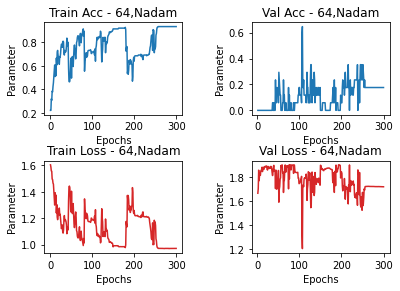

In [57]:
optimizer,batch_size="Nadam",64
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print("Test accuracy = ", acc)

fig, axs = plt.subplots(2, 2)

# axs[0].plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'])
# axs[0].set_title(f'Acc - {lossFxn[:3]},{batch_size},{optimizer}')
# axs[1].plot(range(1,len(history.history['loss'])+1),history.history['loss'],'tab:red')
# axs[1].set_title(f'Loss - {lossFxn[:3]},{batch_size},{optimizer}')

axs[0, 0].plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'])
axs[0, 0].set_title(f'Train Acc - {batch_size},{optimizer}')
axs[1, 0].plot(range(1,len(history.history['loss'])+1),history.history['loss'],'tab:red')
axs[1, 0].set_title(f'Train Loss - {batch_size},{optimizer}')
axs[0, 1].plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'])
axs[0, 1].set_title(f'Val Acc - {batch_size},{optimizer}')
axs[1, 1].plot(range(1,len(history.history['val_loss'])+1),history.history['val_loss'],'tab:red')
axs[1, 1].set_title(f'Val Loss - {batch_size},{optimizer}')

'''axs[0, 0].plot(history.history['accuracy'])
axs[0, 0].set_title('Train dataset Accuracy')
axs[0, 1].plot(history.history['loss'])
axs[0, 1].set_title('Training Loss')
axs[1, 0].plot(history.history['val_accuracy'])
axs[1, 0].set_title('Validation dataset Accuracy')
axs[1, 1].plot(history.history['val_loss'])
axs[1, 1].set_title('Validation Loss')'''
for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Parameter')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# '''for ax in axs.flat:
#     ax.label_outer()'''
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.5,hspace=0.5)
# plt.savefig(f"/content/drive/MyDrive/Emotional_AI_Chatbot/plots3/Row{j}.png")
j+=1
plt.show()

In [23]:
# Emoji key:
# ❤️ = Angry
# ⚾ = Anxious
# 😄 = Confident
# 😞 = Happy
# 🍴 = Sad

def label_to_emotion(label):
  if label == 0:
    return "--> Angry"
  elif label == 1:
    return "--> Anxious"
  elif label == 2:
    return "--> Confident"
  elif label == 3:
    return "--> Happy"
  else:
    return "--> Sad"

In [ ]:

phrases=["Why are you so bad", "I am concerned", "We will succeed", "That was a really good movie", "My girlfriend dumped me"]
phrase = phrases[0]
x_test = np.array([phrase])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
output = np.argmax(model.predict(X_test_indices))

print(x_test[0] + ' ' + label_to_emotion(output))

# Keep in mind that sentences can correspond to multiple emotion classes - even if it doesn't match what you originally thought, it might make sense.